In [ ]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
import torch
print(torch.__version__)

import gzip
import pickle

<img src="../img/intro-paranal.jpg">

# Estrellas variables

- Estrellas cuyo brillo varía en el tiempo
- Existen distintas razones que explican estas variaciones

## Estrellas variables pulsantes
- Estrellas que pulsan radialmente
- Se expanden y contraen de forma regular y periódica
- Ejemplos: RR Lyrae y Cefeidas

<center>
<a href="https://www.youtube.com/watch?v=sXJBrRmHPj8">
    <img src="https://media.giphy.com/media/QP4taxvfVmVEI/giphy.gif" width="400">
</a>
</center>

## Sistemas eclipsantes binarios

- Sistemas de dos estrellas
- Su plano de rotación está alineado con la Tierra
- Desde nuestro punto de vista, vemos como el brillo crece y decrece por los eclipses mutuos
<center>
<table>
    <tr><td>
        <a href="http://www.physast.uga.edu/~rls/astro1020/ch16/ovhd.html">
            <img src="../img/intro-eb.gif" width="300">
        </a>
    </td>
    <td>
        <a href="https://en.wikipedia.org/wiki/File:Algol_AB_movie_imaged_with_the_CHARA_interferometer_-_labeled.gif">
            <img src="https://media.giphy.com/media/aYb0Ob2GHJ280/giphy.gif" width="300">
        </a>
    </td></tr>
</table>
</center>

# ¿Por qué es interesante estudiar estos objetos?


Con RR Lyrae y Cefeidas se pueden calcular distancias y hacer mapas de nuestro vecindario galáctico

<table>
    <tr><td>   
        <img src="../img/period-luminosity-relation.gif" width="400">
    </td><td>
        <img src="../img/intro-milky-way.jpg" width="400">
    </td></tr>
</table>


La variabilidad nos da información de su física, podemos entender mejor los procesos estelares

<center>
<a href="http://www.atnf.csiro.au/outreach/education/senior/astrophysics/variable_types.html">
    <img src="../img/variable-star-classification.gif" width="400">
</a>
</center>


# Curvas de luz

- Son series de tiempo de flujo o brillo estelar en una cierta frecuencia (banda de paso)
- Este brillo "aparente" se estima usando **Fotometría**
- Las curvas de luz son fundamentales para estudiar las estrellas variables

<table><tr><td>
    <img src="../img/intro-vista.png" width="250">
</td><td>
    <img src="../img/intro-sources.png" width="300">
</td></tr></table>

<center>
    <img src="../img/intro-sources-time.png" width="600">
</center>

# Inspeccionando curvas de luz

Tipicamente la curva de luz es un archivo de texto con tres columnas (mínimo)
- **Modified Julian Data (MJD):** Tiempo en días
- **Magnitude:** Brillo relativo en escala logarítima (más magnitude significa menos brillante)
- **Error:** Estimación del error fotométrico de la magnitud, se interpreta como una desviación estándar

In [ ]:
with gzip.open("../data/lc_data.pgz", mode="r") as f:
    lc_data = pickle.load(f)
    
lc_periods = pickle.load(open("../data/lc_periods.pkl", "rb"))

fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)
mjd, mag, err = lc_data[6].T
ax.errorbar(mjd, mag, err, fmt='.')
ax.invert_yaxis(); 
ax.set_xlabel('Modified Julian Date (MJD)\n ')
ax.set_ylabel('Magnitude');

Podemos notar que

- El muestreo es irregular, existen múltiples "gaps"
- La variance del ruido cambia en el tiempo: Error heterocedastico



# "Doblando una curva"

La curva que acabamos de ver es de una estrella periódica

Podemos estudiar su periodicidad usando la transformación de *epoch folding*

$$
\phi_i = \text{mod}(t_i, P)/P
$$

donde $P$ es el periódo de la curva de luz (debemos conocerlo)

El resultado se conoce como "curva doblada" o diagrama de fase

In [ ]:
def fold(time, period):
    """
    returns phase = time/period - floor(time/period)
    """
    return np.mod(time, period)/period

idx = 6
mjd, mag, err = lc_data[idx].T
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)
phi = fold(mjd, lc_periods[idx])
ax.errorbar(np.hstack((phi, phi+1)), 
            np.hstack((mag, mag)), 
            np.hstack((err, err)), fmt='.')
ax.invert_yaxis(); 
ax.set_ylabel('Magnitude');
ax.set_xlabel('Phase @ Period %0.6f' %(lc_periods[idx]));

¿Qué pasa si no conozco el periódo? ¿Cómo se ve la curva si la doblo con un periódo incorrecto?

In [ ]:
fig, ax = plt.subplots(figsize=(7, 3), tight_layout=True)
period_grid = np.linspace(lc_periods[6]-0.001, lc_periods[6]+0.001, num=100)
phi = fold(mjd, period_grid[0])
line, caps, errorbars = ax.errorbar(np.hstack((phi, phi+1)), 
                                    np.hstack((mag, mag)), 
                                    np.hstack((err, err)), fmt='.')
segs = errorbars[0].get_segments()
ax.invert_yaxis(); 
ax.set_ylabel('Magnitude\n(The smaller the brighter)');

def update(n):
    phi = fold(mjd, period_grid[n])
    for i in range(len(segs)//2):
        segs[i][:, 0] = phi[i]
        segs[i+len(phi)][:, 0] = phi[i]+1

    line.set_xdata(np.hstack((phi, phi+1))) 
    errorbars[0].set_segments(segs)
    ax.set_xlabel('Phase @ Period %0.6f' %(period_grid[n]))

anim = animation.FuncAnimation(fig, update, frames=100, interval=100, repeat=False, blit=True)

# Creando una representación regular a partir de curvas dobladas

- Queremos entrenar un modelo de autoencoder sobre las curvas de luz periódicas
- Asumamos que ya tenemos el periódo de cada curva de luz calculado y guardado
- Podemos normalizar e interpolar las curvas dobladas usando una media movil o una regresión con kernel


In [ ]:
idx = 6
mjd, mag, err = lc_data[idx].T
phi = fold(mjd, lc_periods[idx]) 
w = 1.0/err**2
phi_interp = np.linspace(0, 1, num=40)

fig = plt.figure(figsize=(7, 3), tight_layout=True)
ax1 = plt.subplot2grid((3,1), (0,0), rowspan=2, fig=fig)
ax1.errorbar(phi, mag, err, fmt='.', c='k'); ax1.invert_yaxis();
l1 = ax1.plot(phi_interp, [np.amax(mag)]*len(phi_interp), lw=4)

ax2 = plt.subplot2grid((3,1), (2,0), rowspan=1, fig=fig)
l2 = ax2.plot(phi_interp, np.exp(-0.5*phi_interp**2/0.1**2), lw=4)
mag_interp = np.ones_like(phi_interp)*np.amax(mag)

def update(idx):
    gt = np.exp(-0.5*(phi_interp[idx]-phi)**2/0.05**2)
    mag_interp[idx] = np.sum(w*gt*mag)/np.sum(w*gt)
    l1[0].set_ydata(mag_interp)
    l2[0].set_ydata(np.exp(-0.5*(phi_interp-phi_interp[idx])**2/0.05**2))
anim = animation.FuncAnimation(fig, update, frames=40, interval=100, repeat=False, blit=True)

# Dataset

- Usaremos 5000 curvas de luz del proyecto VVV
- Las primeras 4950 son curvas de luz del bulbo galáctico sin etiqueta
- Las últimas 50 son curvas de luz periódicas de RR Lyrae

La función `featurize_lc` realiza la interpolación, normalización y traslación de las curvas de luz (revisar en clases)

In [ ]:
from utils import featurize_lc, defeaturize_lc
from IPython.display import display
from ipywidgets import Button

phi_interp = np.linspace(0, 1, num=40)
features = np.zeros(shape=(len(lc_data), len(phi_interp)))
weights = np.zeros(shape=(len(lc_data), len(phi_interp)))
norm = np.zeros(shape=(len(lc_data), 3))
for i in range(len(lc_data)):
    features[i, :], weights[i, :], norm[i, :] = featurize_lc(lc_data[i], lc_periods[i], phi_interp)
    
next_button = Button(description="Next")
idx = 4950
fig, ax = plt.subplots(1, 2, figsize=(7, 3), tight_layout=True)

def plot_features(idx):
    ax[0].cla();
    ax[1].cla()
    ax[0].set_title("Idx: %d\nPeriod: %0.6f" %(idx, lc_periods[idx]))
    mag, err = defeaturize_lc(features[idx, :], weights[idx, :], norm[idx, :])
    ax[0].plot(phi_interp, mag, lw=4)
    ax[0].fill_between(phi_interp, (mag-err), (mag+err), alpha=0.5)
    ax[0].set_xlabel('Phase'); 
    ax[1].set_ylabel('Normalized magnitude');
    mjd, mag, err = lc_data[idx][:, 0], lc_data[idx][:, 1], lc_data[idx][:, 2]
    phi = fold(mjd, lc_periods[idx])
    ax[0].errorbar(phi, mag, err, fmt='.', c='k', alpha=0.5, label='data'); 
    ax[0].invert_yaxis()
    ax[1].plot(features[idx, :], 'o')
    ax[1].invert_yaxis()

def on_nbutton_clicked(b):
    global idx
    idx += 1
    plot_features(idx)
                
next_button.on_click(on_nbutton_clicked)
plot_features(idx)
display(next_button)

Dataset y dataloaders para pytorch

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler

lc_dataset = TensorDataset(torch.from_numpy(features.astype('float32')), 
                           torch.from_numpy(weights.astype('float32')),
                           torch.from_numpy(lc_periods.astype('float32')))



np.random.seed(1234) 

# Generate data loaders
P = np.random.permutation(5000)
train_loader = DataLoader(dataset=lc_dataset, batch_size=32, 
                          sampler=SubsetRandomSampler(P[:4000]))
valid_loader = DataLoader(dataset=lc_dataset, batch_size=128, 
                          sampler=SubsetRandomSampler(P[4000:]))

# Tarea: Entrenando un autoencoder

- Entrene un autoencoder variacional para comprimir y visualizar las curvas de luz. Proponga una arquitectura y distribuciones adecuadas para el encoder y decoder. Programe el modelo y la función de costo
- Genere una visualización 2D del espacio latente, como un scatter plot con un punto por curva de luz. Cada punto debe estar centrado en $\mu$ y con barras de error $\sigma$. Las curvas no etiquetadas de color azul y las curvas RR Lyra en color rojo. Realice una visualización interactiva que muestre el dato original y su reconstrucción cuando se selecciona en el espacio latente (ver ejemplo lección 1)
- Obtenga y visualice el espacio latente interpolado. ¿En que parte del espacio latente se ubican las RR Lyrae? Genere 10 realizaciones de curvas de luz de RR Lyrae según la ubicación que decidió en el espacio latente


# Resultados esperados


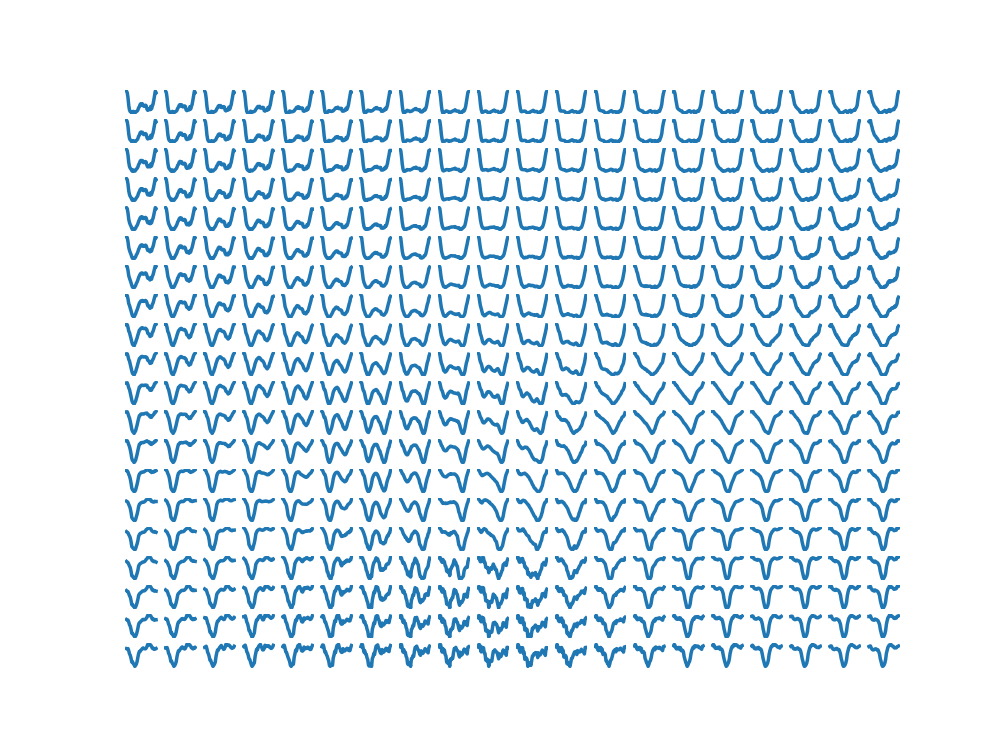


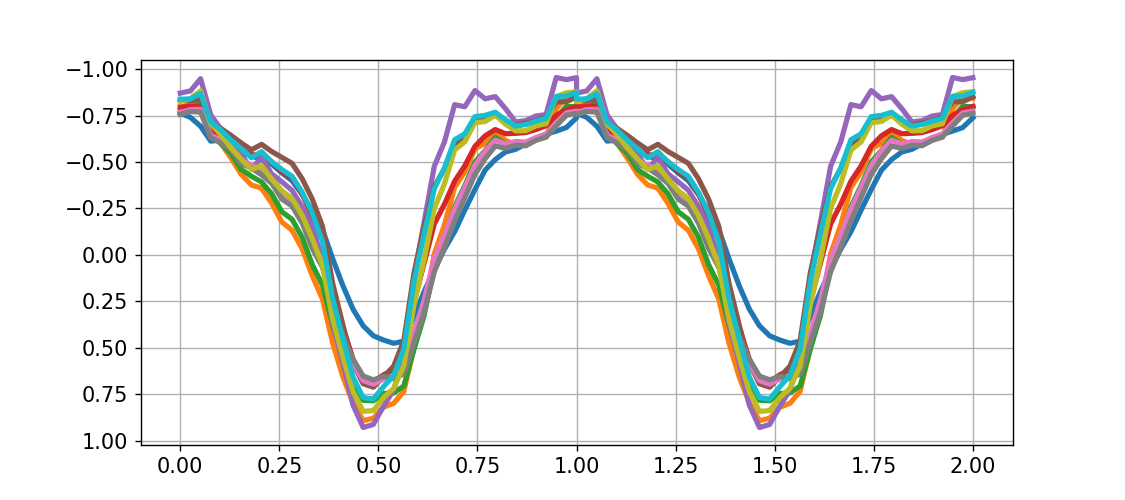

